# Intuitional Description

Meta-analysis provides a systematic approach to **combine results from multiple studies**, increasing statistical power and precision of effect estimates by leveraging the larger aggregate sample size.

# Graphical Summary

![fig](./cartoons/meta_analysis.svg)

# Key Formula

In meta-analysis, the weighted mean effect size for a fixed-effects model is calculated as:

$$\hat{\beta} = \frac{\sum_{i=1}^{k} w_i \hat{\beta}_i}{\sum_{i=1}^{k} w_i}$$

Where:
- $\hat{\beta}$ is the combined effect estimate across all studies
- $\hat{\beta}_i$ is the effect estimate from study $i$
- $w_i$ is the weight assigned to study $i$
- $k$ is the number of studies

# Technical Details

## Multiple Fixed-Effects Models

- Weights for Fixed-Effects
    $$w_i = \frac{1}{v_i}$$
    Where $v_i$ is the within-study variance for study $i$

- Variance of the Combined Estimate
    $$Var(\hat{\beta}) = \frac{1}{\sum_{i=1}^{k} w_i}$$

- Standard Error of the Combined Estimate
    $$SE(\hat{\beta}) = \sqrt{Var(\hat{\beta})} = \sqrt{\frac{1}{\sum_{i=1}^{k} w_i}}$$

## Multiple Random-Effects Models

- Weighted Mean Effect Size
$$\hat{\beta}^* = \frac{\sum_{i=1}^{k} w_i^* \hat{\beta}_i}{\sum_{i=1}^{k} w_i^*}$$

- Weights for Random-Effects
    $$w_i^* = \frac{1}{v_i + \tau^2}$$

    Where $\tau^2$ is the between-study variance

## Meta-Analysis in Genetic Studies

In genetic studies, meta-analysis often combines results from genome-wide association studies (GWAS) across different cohorts with weights either from the sample size or the inverse variance:

- Sample Size Weighting
    $$w_i = \sqrt{N_i}$$

    Where $N_i$ is the sample size of study $i$

- Inverse Variance Weighting
    $$w_i = \frac{1}{SE(\hat{\beta}_i)^2}$$

    Where $SE(\hat{\beta}_i)$ is the standard error of the effect size estimate in study $i$

# Example

This example demonstrates a meta-analysis of genetic variants across two European cohorts. We'll analyze 3 genetic variants (SNPs) that have been genotyped in both cohorts and combine their effects using fixed-effects meta-analysis.

We first generate the summary statistics for 3 variants from two independent European cohorts with different sample sizes (N=8000 and N=5500), and assuming that they are from the same genetic ancestry so they can be meta-analyzed.

Then we perform fixed-effects meta-analysis combining results using:
- Sample size weighting (weight proportional to $\frac{1}{\sqrt{N}}$)
- Inverse variance weighting (weight = $\frac{1}{\text{SE}^2}$)

Lastly we plot the effect size and p-values for each variant and compare the results from separate cohorts and meta-analysis results. We also compare the variance based on the sample size and inverse variance.

In [48]:
# Create summary statistics for two European cohorts
# Cohort 1: European ancestry (N=8000)
cohort1 <- data.frame(
  variant = c("rs1", "rs2", "rs3"),
  beta = c(0.18, -0.09, 0.25),       # Effect sizes
  se = c(0.035, 0.028, 0.055),       # Standard errors
  p_value = c(2.5e-7, 1.3e-3, 5.4e-6), # P-values
  n = c(8000, 8000, 8000)            # Sample size
)

# Cohort 2: European ancestry (N=5500)
cohort2 <- data.frame(
  variant = c("rs1", "rs2", "rs3"),
  beta = c(0.15, -0.03, 0.29),       # Effect sizes
  se = c(0.042, 0.033, 0.063),       # Standard errors
  p_value = c(3.6e-4, 4.4e-1, 4.2e-6), # P-values
  n = c(5500, 5500, 5500)            # Sample size
)

# Display the summary statistics
print("Cohort 1 (European, N=8000):")
print(cohort1)
print("Cohort 2 (European, N=5500):")
print(cohort2)


[1] "Cohort 1 (European, N=8000):"
  variant  beta    se p_value    n
1     rs1  0.18 0.035 2.5e-07 8000
2     rs2 -0.09 0.028 1.3e-03 8000
3     rs3  0.25 0.055 5.4e-06 8000
[1] "Cohort 2 (European, N=5500):"
  variant  beta    se p_value    n
1     rs1  0.15 0.042 3.6e-04 5500
2     rs2 -0.03 0.033 4.4e-01 5500
3     rs3  0.29 0.063 4.2e-06 5500


In [49]:
# Define Function for sample size weighting
sample_size_meta <- function(beta1, n1, beta2, n2) {
  # Calculate weights proportional to sample size
  w1 <- n1
  w2 <- n2
  
  # Combined effect using sample size weights
  beta_meta <- (w1 * beta1 + w2 * beta2) / (w1 + w2)
  
  # Calculate the weight ratio
  weight_ratio <- w2/w1
  
  # Return results
  return(list(
    beta = beta_meta,
    w1 = w1,
    w2 = w2,
    weight_ratio = weight_ratio
  ))
}

# Define Function for inverse variance weighting
inverse_variance_meta <- function(beta1, se1, beta2, se2) {
  # Calculate weights as inverse of variance
  w1 <- 1 / (se1^2)
  w2 <- 1 / (se2^2)
  
  # Combined effect using inverse variance weights
  beta_meta <- (w1 * beta1 + w2 * beta2) / (w1 + w2)
  
  # Standard error of combined estimate
  se_meta <- sqrt(1 / (w1 + w2))
  
  # Z-score
  z_meta <- beta_meta / se_meta
  
  # P-value
  p_meta <- 2 * pnorm(-abs(z_meta))
  
  # Calculate the weight ratio
  weight_ratio <- w2/w1
  
  # Return results
  return(list(
    beta = beta_meta,
    se = se_meta,
    z = z_meta,
    p = p_meta,
    w1 = w1,
    w2 = w2,
    weight_ratio = weight_ratio
  ))
}


In [50]:
# Perform meta-analysis for each variant
results <- data.frame(
  variant = cohort1$variant,
  beta1 = cohort1$beta,
  se1 = cohort1$se,
  p1 = cohort1$p_value,
  n1 = cohort1$n,
  beta2 = cohort2$beta,
  se2 = cohort2$se,
  p2 = cohort2$p_value,
  n2 = cohort2$n,
  beta_n = numeric(3),
  w1_n = numeric(3),
  w2_n = numeric(3),
  weight_ratio_n = numeric(3),
  beta_iv = numeric(3),
  se_iv = numeric(3),
  p_iv = numeric(3),
  w1_iv = numeric(3),
  w2_iv = numeric(3),
  weight_ratio_iv = numeric(3)
)

for (i in 1:nrow(results)) {
  # Sample size weighting
  ss_result <- sample_size_meta(
    results$beta1[i], results$n1[i],
    results$beta2[i], results$n2[i]
  )
  
  # Store sample size weighting results
  results$beta_n[i] <- ss_result$beta
  results$w1_n[i] <- ss_result$w1
  results$w2_n[i] <- ss_result$w2
  results$weight_ratio_n[i] <- ss_result$weight_ratio
  
  # Inverse variance weighting
  iv_result <- inverse_variance_meta(
    results$beta1[i], results$se1[i],
    results$beta2[i], results$se2[i]
  )
  
  # Store inverse variance weighting results
  results$beta_iv[i] <- iv_result$beta
  results$se_iv[i] <- iv_result$se
  results$p_iv[i] <- iv_result$p
  results$w1_iv[i] <- iv_result$w1
  results$w2_iv[i] <- iv_result$w2
  results$weight_ratio_iv[i] <- iv_result$weight_ratio
}

In [51]:
results

variant,beta1,se1,p1,n1,beta2,se2,p2,n2,beta_n,w1_n,w2_n,weight_ratio_n,beta_iv,se_iv,p_iv,w1_iv,w2_iv,weight_ratio_iv
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs1,0.18,0.035,2.5e-07,8000,0.15,0.042,3.6e-04,5500,0.16777778,8000,5500,0.6875,0.16770492,0.02688774,4.454007e-10,816.3265,566.8934,0.6944444
rs2,-0.09,0.028,1.3e-03,8000,-0.03,0.033,4.4e-01,5500,-0.06555556,8000,5500,0.6875,-0.06488521,0.02135026,2.372990e-03,1275.5102,918.2736,0.7199265
rs3,0.25,0.055,5.4e-06,8000,0.29,0.063,4.2e-06,5500,0.26629630,8000,5500,0.6875,0.26730054,0.04143243,1.107624e-10,330.5785,251.9526,0.7621567


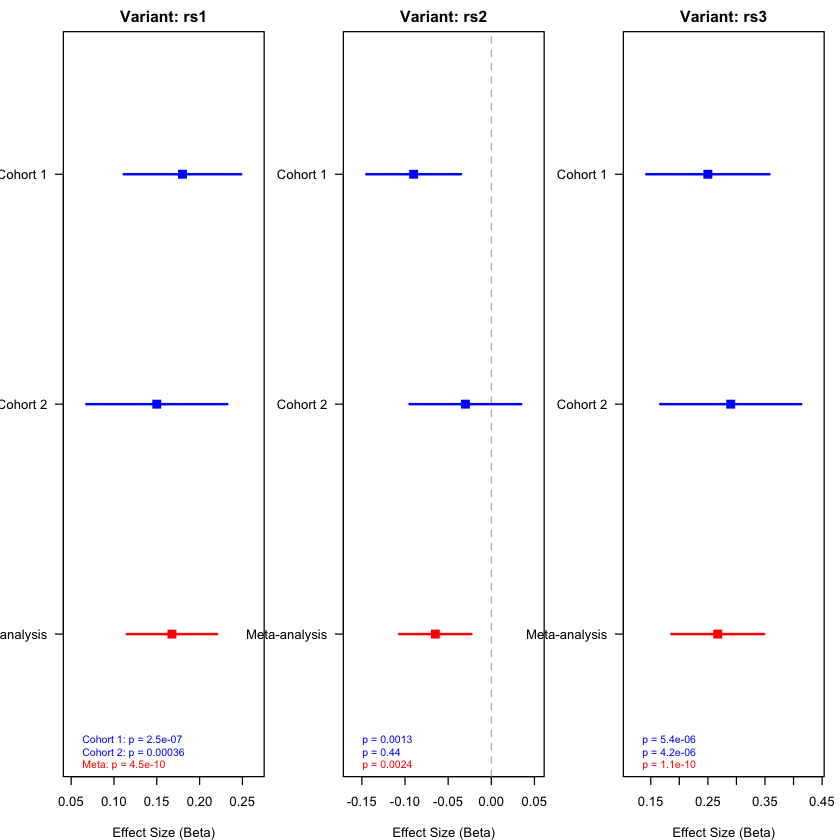

In [52]:
# Add visualization to compare individual cohort results with meta-analysis results
# Set up the plotting area with multiple panels
par(mfrow = c(1, 3), mar = c(4, 4, 2, 1))

# For each variant, create a forest plot
for (i in 1:nrow(results)) {
  variant_name <- results$variant[i]
  
  # Prepare data for plotting
  y_positions <- c(3, 2, 1)  # Positions for Cohort 1, Cohort 2, Meta-analysis
  effect_sizes <- c(results$beta1[i], results$beta2[i], results$beta_iv[i])
  lower_ci <- c(
    results$beta1[i] - 1.96 * results$se1[i],
    results$beta2[i] - 1.96 * results$se2[i],
    results$beta_iv[i] - 1.96 * results$se_iv[i]
  )
  upper_ci <- c(
    results$beta1[i] + 1.96 * results$se1[i],
    results$beta2[i] + 1.96 * results$se2[i],
    results$beta_iv[i] + 1.96 * results$se_iv[i]
  )
  
  # Set up empty plot with appropriate range
  x_range <- range(c(lower_ci, upper_ci))
  x_padding <- 0.1 * (x_range[2] - x_range[1])
  x_range <- x_range + c(-x_padding, x_padding)
  
  plot(
    NULL, 
    xlim = x_range, 
    ylim = c(0.5, 3.5), 
    yaxt = "n", 
    ylab = "", 
    xlab = "Effect Size (Beta)", 
    main = paste("Variant:", variant_name)
  )
  
  # Add horizontal reference line at x=0
  abline(v = 0, lty = 2, col = "gray")
  
  # Add the effect sizes and confidence intervals
  for (j in 1:3) {
    # Point estimate
    points(effect_sizes[j], y_positions[j], pch = 15, cex = 1.5, 
           col = ifelse(j == 3, "red", "blue"))
    
    # Confidence interval
    lines(
      c(lower_ci[j], upper_ci[j]), 
      c(y_positions[j], y_positions[j]), 
      lwd = 2, 
      col = ifelse(j == 3, "red", "blue")
    )
  }
  
  # Add y-axis labels
  axis(
    2, 
    at = y_positions, 
    labels = c("Cohort 1", "Cohort 2", "Meta-analysis"), 
    las = 1
  )
  
  # Add legend for p-values at the bottom
  if (i == 1) {  # Only for the first plot
    legend_text <- c(
      paste("Cohort 1: p =", format(results$p1[i], digits = 2)),
      paste("Cohort 2: p =", format(results$p2[i], digits = 2)),
      paste("Meta: p =", format(results$p_iv[i], digits = 2))
    )
  } else {
    legend_text <- c(
      paste("p =", format(results$p1[i], digits = 2)),
      paste("p =", format(results$p2[i], digits = 2)),
      paste("p =", format(results$p_iv[i], digits = 2))
    )
  }
  
  legend(
    "bottomleft", 
    legend = legend_text,
    text.col = c("blue", "blue", "red"),
    bty = "n", 
    cex = 0.8
  )
}

# Reset plotting parameters



Summary of Meta-Analysis Results:
  variant      beta_n     beta_iv         p_iv
1     rs1  0.16777778  0.16770492 4.454007e-10
2     rs2 -0.06555556 -0.06488521 2.372990e-03
3     rs3  0.26629630  0.26730054 1.107624e-10


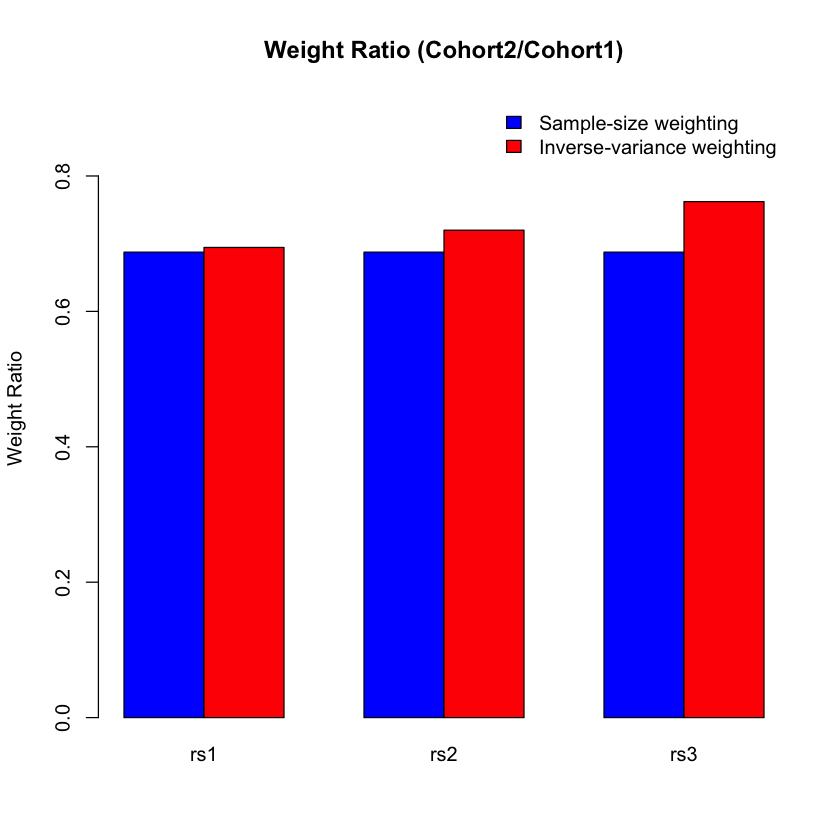

In [ ]:
# Create a summary table to visualize weight ratios
barplot(
  rbind(results$weight_ratio_n, results$weight_ratio_iv),
  beside = TRUE,
  names.arg = results$variant,
  col = c("blue", "red"),
  main = "Weight Ratio (Cohort2/Cohort1)",
  ylab = "Weight Ratio",
  ylim = c(0, max(c(results$weight_ratio_n, results$weight_ratio_iv)) * 1.2)
)

# Add a reference line at ratio = 1 (equal weights)
abline(h = 1, lty = 2)

# Add legend
legend(
  "topright",
  legend = c("Sample-size weighting", "Inverse-variance weighting"),
  fill = c("blue", "red"),
  bty = "n"
)

# Print a summary of the meta-analysis results
cat("\nSummary of Meta-Analysis Results:\n")
print(results[, c("variant", "beta_n", "beta_iv", "p_iv")])

# Supplementary

## Generate and Perform GWAS for Study 1

In this section, we generate the genotype matrix for Study 1, which consists of **100 individuals and 3 variants (SNPs)**. Each individual's genotype is represented by values 0, 1, or 2. The matrix is then standardized, meaning each column (representing a variant) will have a mean of 0 and variance of 1. After that, we simulate the response variable and perform the GWAS analysis by **running OLS regression for each SNP individually**.

Steps:
- Create a random genotype matrix for 100 individuals and 3 variants.
- Standardize the genotype matrix.
- Generate the response variable for 100 individuals.
- Perform OLS regression for each SNP to calculate the estimated effect sizes and standard errors.

In [ ]:
# ---- Study 1 (100 individuals) ----
N1 <- 100  # Number of individuals in study 1
M <- 3     # Number of SNPs (variants)

# Create a random genotype matrix (0, 1, 2 values for each SNP)
X_raw1 <- matrix(sample(0:2, N1 * M, replace = TRUE), nrow = N1, ncol = M)

# Adding row and column names for Study 1
rownames(X_raw1) <- paste("Individual", 1:N1)
colnames(X_raw1) <- paste("Variant", 1:M)

# Standardize genotype matrix for Study 1
X1 = scale(X_raw1, scale=TRUE)

# Simulate phenotype with the true effect size on the causal SNP (SNP 2)
y1 <- true_effect_size * X1[, true_causal_variant] + rnorm(N1, mean = 0, sd = 1)

# Perform GWAS-style analysis for Study 1: Test each SNP independently using OLS
p_values1 <- numeric(M)  # Store p-values for Study 1
betas1 <- numeric(M)     # Store estimated effect sizes for Study 1
se1 <- numeric(M)        # Store standard errors for Study 1

for (j in 1:M) {
  SNP <- X1[, j]  # Extract genotype for SNP j
  model <- lm(y1 ~ SNP)  # OLS regression: Trait ~ SNP
  summary_model <- summary(model)
  
  # Store p-value, effect size (coefficient), and standard error
  p_values1[j] <- summary_model$coefficients[2, 4]  # p-value for SNP effect
  betas1[j] <- summary_model$coefficients[2, 1]     # Estimated beta coefficient
  se1[j] <- summary_model$coefficients[2, 2]        # Standard error of beta
}

# Create results table for Study 1
gwas_results1 <- data.frame(Variant = colnames(X1), Beta = betas1, SE = se1, P_Value = p_values1)
gwas_results1

## Generate and Perform GWAS for Study 2
In this section, we generate the genotype matrix for Study 2, which consists of **500 individuals and 3 variants (SNPs)**. Similar to Study 1, the genotype matrix is standardized. The response variable is also simulated, and we perform the GWAS analysis by running OLS regression for each SNP independently to obtain the effect sizes and standard errors.

The steps are the same as Study 1.

In [ ]:
# ---- Study 2 (500 individuals) ----
N2 <- 500  # Number of individuals in study 2

# Create a random genotype matrix (0, 1, 2 values for each SNP)
X_raw2 <- matrix(sample(0:2, N2 * M, replace = TRUE), nrow = N2, ncol = M)

# Adding row and column names for Study 2
rownames(X_raw2) <- paste("Individual", 1:N2)
colnames(X_raw2) <- paste("Variant", 1:M)

# Standardize genotype matrix for Study 2
X2 = scale(X_raw2, scale=TRUE)

# Simulate phenotype with the true effect size on the causal SNP (SNP 2)
y2 <- true_effect_size * X2[, true_causal_variant] + rnorm(N2, mean = 0, sd = 1)

# Perform GWAS-style analysis for Study 2: Test each SNP independently using OLS
p_values2 <- numeric(M)  # Store p-values for Study 2
betas2 <- numeric(M)     # Store estimated effect sizes for Study 2
se2 <- numeric(M)        # Store standard errors for Study 2

for (j in 1:M) {
  SNP <- X2[, j]  # Extract genotype for SNP j
  model <- lm(y2 ~ SNP)  # OLS regression: Trait ~ SNP
  summary_model <- summary(model)
  
  # Store p-value, effect size (coefficient), and standard error
  p_values2[j] <- summary_model$coefficients[2, 4]  # p-value for SNP effect
  betas2[j] <- summary_model$coefficients[2, 1]     # Estimated beta coefficient
  se2[j] <- summary_model$coefficients[2, 2]        # Standard error of beta
}

# Create results table for Study 2
gwas_results2 <- data.frame(Variant = colnames(X2), Beta = betas2, SE = se2, P_Value = p_values2)
gwas_results2

## Meta-Analysis

After performing the GWAS in both Study 1 and Study 2, we conduct a **meta-analysis** to combine the results from both studies and obtain a more robust estimate of the true effect size. 

The meta-analysis is performed using **inverse variance weighting**, where the effect size estimates from each study are weighted by the inverse of their squared standard errors. This ensures that studies with more precise estimates (smaller standard errors) contribute more to the combined estimate. The weighted average of the effect sizes from both studies is calculated, providing a summary effect size that incorporates data from both studies. This meta-analysis helps to obtain a more accurate and consistent estimate of the effect of each SNP on the trait across different sample sizes.

In [ ]:
# ---- Meta-Analysis (Inverse Variance Weighting) ----

# Calculate weights (inverse of variance)
w1 <- 1 / (se1^2)  # Weights for Study 1
w2 <- 1 / (se2^2)  # Weights for Study 2

# Calculate combined effect size using inverse variance weighting
combined_betas <- (w1 * betas1 + w2 * betas2) / (w1 + w2)

# Calculate variance of the combined effect size
combined_variance <- 1 / (w1 + w2)
combined_se <- sqrt(combined_variance)

# Calculate p-values for each study's effect size
p_value_study1 <- 2 * (1 - pnorm(abs(betas1 / se1)))  # P-value for Study 1
p_value_study2 <- 2 * (1 - pnorm(abs(betas2 / se2)))  # P-value for Study 2

# Calculate p-value for the combined effect size
p_value_combined <- 2 * (1 - pnorm(abs(combined_betas / combined_se)))

# Combine the results
meta_analysis_results <- data.frame(
  Variant = colnames(X1),
  Beta_Study1 = betas1, SE_Study1 = se1, P_Value_Study1 = p_value_study1,
  Beta_Study2 = betas2, SE_Study2 = se2, P_Value_Study2 = p_value_study2,
  Combined_Beta = combined_betas, Combined_SE = combined_se,
  Combined_P_Value = p_value_combined
)

print("Meta-Analysis Results (Inverse Variance Weighting):")
meta_analysis_results


The fixed effect model assumes that the true effect size of each variant is the same across all studies. For example, in Variant 2, the estimated effect sizes from both studies (0.4060 from Study 1 and 0.4289 from Study 2) are very similar, suggesting that the true effect size may be constant across studies. By using a fixed effect model, we can combine these estimates into a single, more precise effect size (0.4256 for Variant 2), taking into account the study precisions through inverse variance weighting.

Meta-analysis is essential here because it allows us to combine results from multiple studies, adjusting for differences in sample sizes and precision. Study 2 has more individuals and therefore a more precise estimate of the effect size, so it contributes more to the combined estimate. 

The meta-analysis ensures that the combined effect size is not only a weighted average of the studies' estimates but also accounts for the variability between studies, offering a more reliable and accurate estimate of the true effect size.

> slide 146 in Hailiang Huang's slides
>
> slide 244-246 from GW

When we move from one study to multiple studies (e.g., in a meta-analysis), you may want to test whether a particular SNP has the same effect across studies. This is where the idea of sharing a common effect size becomes relevant.

In a meta-analysis of multiple studies, we often assume that the true effect size for each SNP is **the same across all studies** (but possibly with different observed effect sizes due to different sample sizes, populations, etc.). The meta-analysis combines results from multiple studies, and the fixed effect model in this context would assume that the SNP's effect size is consistent across all the studies being analyzed.

**[FIXME]** should we introduce the concept of meta-analysis first before discussing about FEM and REM?

---



In a fixed effect meta-analysis, we assume that the observed effect size $\hat{\beta}_k$ from study $k$ follows a normal distribution:

$$
\hat{\beta}_k \sim N(\beta_j, s_k^2)
$$

Where:
- $\beta_j$ is the **true effect size** for SNP $j$, assumed to be the same across all studies.
- $s_k^2$ is the **variance** of the observed effect size $\hat{\beta}_k$ for study $k$, reflecting the precision of the estimate in study $k$.



## Combined Estimate of Effect Size

   The goal of the meta-analysis is to estimate the true effect size $\beta_j$ from the observed effect sizes $\hat{\beta}_k$ across all studies. We do this by calculating a **weighted average** of the observed effect sizes, where the weights are proportional to the precision of each estimate (i.e., inversely proportional to the variance $s_k^2$):

   $$
   \hat{\beta}_j = \frac{\sum_{k=1}^{K} w_k \hat{\beta}_{k}}{\sum_{k=1}^{K} w_k}
   $$

   Where:
   - $w_k = \frac{1}{s_k^2}$ is the weight for study $k$.




## Maximum Likelihood Estimation (MLE) of the Summary Effect

   The MLE for the summary effect size $\beta_j$ under the fixed effect model is equivalent to the **inverse variance weighting**. This is because we assume that the observed effect sizes $\hat{\beta}_k$ are normally distributed with mean $\beta_j$ and variance $s_k^2$. The likelihood function for the fixed effect model is maximized by weighting the observed effect sizes by the inverse of their variances:

   $$
   \hat{\beta}_j = \frac{\sum_{k=1}^{K} \frac{\hat{\beta}_k}{s_k^2}}{\sum_{k=1}^{K} \frac{1}{s_k^2}}
   $$

   This is the **inverse variance weighting** formula used to combine the effect sizes from different studies in a meta-analysis.



## Heterogeneity Assessment

Heterogeneity assessment is a crucial component of meta-analysis because it evaluates whether the observed effect sizes across different studies are more variable than would be expected by chance alone. This helps us understand if we're truly measuring the same effect across studies or if there are underlying differences. Below are several ways to measure it.

### Cochran's Q Statistic:
$$Q = \sum_{i=1}^{k} w_i(\hat{\beta}_i - \hat{\beta})^2$$

This statistic follows a $\chi^2$ distribution with $k-1$ degrees of freedom under the null hypothesis of homogeneity.

### $I^2$ Statistic (Percentage of Variation Due to Heterogeneity)
$$I^2 = \max\left\{0, \frac{Q-(k-1)}{Q} \times 100\%\right\}$$

- Interpretation:
  - 0-25%: Might not be important
  - 25-50%: Moderate heterogeneity
  - 50-75%: Substantial heterogeneity
  - 75-100%: Considerable heterogeneity
